In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
plt.style.use('ggplot')
import torch
from torch import nn
from torch.utils.data import random_split,  DataLoader,  TensorDataset
from torch.distributions import multivariate_normal,  binomial
from sklearn import datasets
import numpy as np
from torch.autograd import Variable
import ipdb
from sklearn.mixture import GaussianMixture
from torchdiffeq import odeint,  odeint_adjoint
from tqdm import tqdm
random_seed = 0
n_samples = 400
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(random_seed)
plt.style.use('seaborn-talk')

# Utils

In [2]:
def phase_evol(phases, masks, save_name=None):
        phases = np.squeeze(np.array(phases, dtype=np.float32))
        phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
        if masks is not None:
            group_num = masks.shape[1]
            annot_bool = [True] * group_num
            colors = {}
            for num in range(group_num):
                mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                        (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
                colors[num] = num*50#(mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
            for i in range(phases.shape[1]):
                for num in range(group_num):
                    if masks[0][num][i]:
                        plt.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                        if annot_bool[num]:
                            plt.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num+1),
                                     horizontalalignment='left', size='small', color=plt.cm.hsv(colors[num]))
                            annot_bool[num] = False
            plt.xlabel('Time')
            plt.ylabel('Phase')
            plt.title('Phase Evolution')
            plt.ylim([0,2*np.pi])
        else:
            for i in range(phases.shape[1]):
                plt.plot(phases[:, i])
            plt.xlabel('Time')
            plt.ylabel('Phase')
            plt.title('Phase Evolution')
        plt.tight_layout()
        if save_name is not None:
            plt.savefig(save_name + '.png')
        else:
            plt.show()
        plt.close()
        

def phase_evol_ax(ax, phases, masks, save_name=None):
    phases = np.squeeze(np.array(phases, dtype=np.float32))
    phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    if masks is not None:
        group_num = masks.shape[1]
        annot_bool = [True] * group_num
        colors = {}
        for num in range(group_num):
            mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                    (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
            colors[num] = num*50#(mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
        for i in range(phases.shape[1]):
            for num in range(group_num):
                if masks[0][num][i]:
                    ax.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                    if annot_bool[num]:
                        ax.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num+1),
                                 horizontalalignment='left', size='small', color=plt.cm.hsv(colors[num]))
                        annot_bool[num] = False
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')
        ax.set_ylim([0,2*np.pi])
    else:
        for i in range(phases.shape[1]):
            ax.set_plot(phases[:, i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')


class Moons(object):
    def __init__(self, noise = 0.05, random_state=1):
        self.noise = noise
        self.random_state = random_state
        self.n_components = 2

    def sample(self, n_samples=400):
        x, y = datasets.make_moons(n_samples,
                            noise = self.noise,
                             random_state=self.random_state)
        return [torch.tensor(x), torch.tensor(y)]

    def train_test(selfn_samples_trainn_samples_test):
        return self.sample(n_samples_train), self.sample(n_samples_test)
    
        
class Circles(object):
    def __init__(selffactor = 0.5, random_state=1):
        self.factor = factor
        self.random_state = random_state
        self.n_components = 2

    def sample(self, n_samples=400):
        x, y = datasets.make_circles(n_samples,
                            factor = self.factor,
                             random_state=self.random_state)
        return [torch.tensor(x), torch.tensor(y)]

    def train_test(selfn_samples_trainn_samples_test):
        return self.sample(n_samples_train), self.sample(n_samples_test)

class GMM(object):
    def __init__(self, n_components, centroids, cov_matrices):
        self.n_components = n_components
        self.centroids = centroids
        self.cov_matrices = cov_matrices

    def one_sampling(self,statistics):
        return np.random.multivariate_normal(statistics[0], statistics[1])

    def sample(self, n_samples):
        idx = np.random.randint(0, self.n_components,n_samples)
        list_stat = [[self.centroids[i],self.cov_matrices[i]] for i in idx]
        return [torch.tensor((np.vstack(list(map(self.one_sampling,list_stat))))), torch.tensor(idx)]

    def train_test(selfn_samples_trainn_samples_test):
        return self.sample(n_samples_train), self.sample(n_samples_test)
    
class fixed_graph(object):
    def __init__(self, n_nodes, n_groups):
        self.n_components = n_groups
        self.n_nodes = n_nodes

    def sample(self,zzz):
        n_group_card = self.n_nodes//self.n_components
        n_group_rest = self.n_nodes%self.n_components
        idx = np.concatenate([np.tile(np.arange(self.n_components),(n_group_card)),np.arange(n_group_rest)])
        return [torch.FloatTensor(()), torch.tensor(idx)]

### Loss function

In [3]:
def circular_moments_batch(phases, masks, lasts=50, split = False, burn_in_prop=.5):
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    
    burn_in_steps = int(burn_in_prop * T)
    masked_phases = phases.unsqueeze(1) * masks
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(-1)/num_groups

    mean_angles = torch.atan2(yy.sum(-1),xx.sum(-1))
    desynch = 0
    for m in np.arange(1, int(np.floor(num_groups/2.))+1):
#         K_m = 1 if m < int(np.floor(num_groups/2.)) + 1 else -1
        desynch += (1.0 / (2* num_groups * m**2)) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
        
    #for m in range(1,num_groups):
    #    desynch += (1.0 / 2*num_groups*m**2) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
    #desynch += (1.0 / 2*num_groups*num_groups**2) * (torch.cos(num_groups*mean_angles).sum(-1)**2 + torch.sin(num_groups*mean_angles).sum(-1)**2)
        
    loss = (synch + desynch)
    
    if split == True:
        return loss[burn_in_steps:,...].mean(), synch[burn_in_steps:,...].mean(), desynch[burn_in_steps:,...].mean()
    else:
        return loss[burn_in_steps:,...].mean()

### Adjoint method

In [29]:
class KuraODE(nn.Module):
        
    """
    torch.nn.Module that defines the infinitesimal evolution of the ODE : df/dt = module(t,\\theta),
    - Handles batchs of images by flattening the batch dim and treat everything as a single ODE,
    - Requires the update of the couplings parameters at every call to get the gradient d(couplings)/dL,
    """

    def __init__(self):
        super(KuraODE, self).__init__()
        #self.couplings = torch.nn.Parameter(torch.eye(1),requires_grad=True) #placeholder,

    def update(self, couplings):
        self.couplings = torch.nn.Parameter(couplings,requires_grad=True)
        self.nfe = 0

    def forward(self, t, phase):
        self.nfe+=1
        phase = phase.reshape(self.couplings.shape[0],-1).float()
        n = self.couplings.shape[0]
        delta_phase = (self.couplings.unsqueeze(0)@torch.sin(phase).float() * torch.cos(phase) - 
        self.couplings.unsqueeze(0)@torch.cos(phase).float() * torch.sin(phase)) / n 

        return delta_phase.squeeze(-1)

In [30]:
class KuraTrainer(object):
        def __init__(self, model, data_generator, batch_size, LossFunc, num_features=32):
            super(KuraTrainer, self).__init__()
            self.data_generator = data_generator
            self.batch_size = batch_size
            self.LossFunc = LossFunc
            self.num_features=num_features
            self.model = model
            
        def init_phase(self,batch_size):
            #self.init = torch.zeros((batch_size,)).float().unsqueeze(0)
            self.init = torch.normal(np.pi,1,(batch_size,)).float().unsqueeze(0)
            #self.init = torch.FloatTensor(batch_size,).uniform_(0, 2*np.pi).unsqueeze(0)
            return self.init
            #return torch.normal(np.pi,0.05,(batch_size,)).float().unsqueeze(0)
        
        def plot_data(self,num_points):
            a, idx = self.data_generator.sample(num_points)
            plt.scatter(a[:,0],a[:,1],c=idx)
            plt.show()
            
        def train_same_batch(self,gradient_steps=50,lr=0.1, alpha=.1, normalized=False, eps=1e-12,num_loss=0,burn_in_prop=.5, verbose=0):
            self.lh = []
            opt = torch.optim.Adam(self.model.parameters(), lr=lr)
            self.init = self.init_phase(self.batch_size)
            batch, idx = self.data_generator.sample(self.batch_size)
            self.batch = batch.float()
            self.idx = idx.float()
            masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
            masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
            
            for _ in range(gradient_steps):
                
                init_phase = self.init #self.init_phase(self.batch_size)
                
                #Training by gradient descent via adjoint sensitivity method
                opt.zero_grad()
                phase, couplings = self.model(self.init, self.batch )
                loss = LossFunc(phase, masks,split=True, burn_in_prop=burn_in_prop)
                self.lh.append(loss[num_loss].detach().numpy())
                loss[num_loss].backward()
                if verbose > 0: 
                    if _ % 10 == 0: 
                        print('Step: {}. Loss: {}'.format(_, loss))
                        print('Gradient norm: {}'.format(torch.pow(self.model.ODEDynamic.couplings.grad,2).sum().numpy()))
                self.model.couplings.backward(gradient=self.model.ODEDynamic.couplings.grad)
                opt.step()
            return
        
        def train(self,gradient_steps=50,lr=0.1, alpha=.1, normalized=False, eps=1e-12,num_loss=0,burn_in_prop=.5, verbose=0):
            self.lh = []
            opt = torch.optim.Adam(self.model.parameters(), lr=lr)
            self.init = self.init_phase(self.batch_size)

            for _ in range(gradient_steps):

                with torch.no_grad():
                    batch, idx = self.data_generator.sample(self.batch_size)
                    self.batch = batch.float()
                    self.idx = idx.float()
                    masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
                    masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
                    init_phase = self.init_phase(self.batch_size) #self.init_phase(self.batch_size)

                #Training by gradient descent via adjoint sensitivity method
                opt.zero_grad()
                phase, couplings = self.model(self.init, self.batch)
                loss = LossFunc(phase, masks,split=True, burn_in_prop=burn_in_prop)
                self.lh.append(loss[num_loss].detach().numpy())
                loss[num_loss].backward()
                if verbose > 0: 
                    if _ % 10 == 0: 
                        print('Step: {}. Loss: {}\\n'.format(_, loss))
                        print('Gradient norm: {}'.format(torch.pow(self.model.ODEDynamic.couplings.grad,2).sum().numpy()))
                self.model.couplings.backward(gradient=self.model.ODEDynamic.couplings.grad)
                opt.step()
            return

In [52]:
class Kuramoto_features(nn.Module):

    def __init__(self,
                 batch_size = 32,
                 num_hid = 32,
                 input_size = 2,
                 feature_size = 10,
                 steps=100,
                 time=1500,
                 alpha=1e-1,
                 device='cpu',
                 adjoint=True,
                 gain=1.):

        super(Kuramoto_features, self).__init__()

        #Integration parameters
        self.adjoint=adjoint
        self.steps = steps
        self.time = time
        self.alpha=alpha
        self.integration_time =  torch.linspace(0., self.time, self.steps).float()
        self.ODEDynamic = KuraODE()
        self.tol = 1e-5
        self.atol = 1e-5
        self.max_steps = 1000

        #Problem dimensions
        self.batch_size = batch_size
        self.indim = input_size
        self.outdim = feature_size
        self.device = device
        self.gain = gain

        # Definition of couplings
        #self.couplings = torch.nn.Parameter(torch.rand(batch_size,batch_size) - .5,requires_grad=True)

        # Definition of coupling inference model
        self.layers = torch.nn.Sequential(torch.nn.Linear(self.indim, num_hid),
                          torch.nn.ReLU(),
                          torch.nn.Linear(num_hid,num_hid),
                          torch.nn.ReLU(),             
                          torch.nn.Linear(num_hid,self.outdim))

        for layer in self.layers:
            try :
                #torch.nn.init.orthogonal_(layer.weight, gain=1)
                #torch.nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='tanh')
                torch.nn.init.xavier_normal_(layer.weight, gain=self.gain)
                #torch.nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='tanh')
            except:
                pass

    def sample_couplings(self, batches, num_samples=64):
        all_couplings = []
        for batch in batches:
            all_couplings.append(self.layers(batch.reshape(1,-1)).reshape(self.batch_size,self.batch_size).detach())
        all_couplings = torch.stack(all_couplings).reshape(-1).numpy()
        return all_couplings

    def forward(self,init_phase, x):

        #Infer couplings 
        features = self.layers(x)
        #print(features[:10])
        features = features / torch.pow(features,2).sum(-1).unsqueeze(1)
        couplings = features @ features.T
        couplings = couplings / torch.pow(couplings,2).sum(-1).unsqueeze(1) - 0.1
        #couplings = couplings - torch.mean(couplings)
        self.couplings = couplings

        self.ODEDynamic.update(self.couplings)

        #Run Dynamic with adaptative solver
        if self.adjoint:
            trajectory = odeint_adjoint(self.ODEDynamic, init_phase, self.integration_time,
                                   rtol=self.tol, atol=self.atol, method='euler')
        else:
            trajectory = []
            phase = init_phase
            for t in range(self.T):
                phase = phase + self.alpha*self.ODEDynamic.forward(t, phase)
                trajectory.append(phase)
            trajectory = torch.stack(trajectory)

        return trajectory, couplings

# GMM

In [53]:
num_seeds = 1
all_losses = []
all_init_phase = []
all_init_coupling = []
bs = 100

for seed in range(num_seeds):
    print(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    Model = Kuramoto_features(batch_size = bs, num_hid = 100,input_size=2, feature_size=10, device='cpu', adjoint=True,gain=0.5)
    gmm = GMM(n_components=5, centroids=[[3,-3],[4,8],[-3,3],[-2,-5],[0,10]], cov_matrices=20*np.array([0.05*np.eye(2),0.02*np.diag([1,5]),0.02*np.eye(2),0.01*np.eye(2),0.01*np.eye(2)]))
#   gmm = GMM(n_components=2, centroids=[[2,-2],[-2,2]], cov_matrices=[0.5*np.eye(2),0.2*np.eye(2)])
#   gmm = GMM(n_components=3, centroids=[[2,-2],[4,4],[-3,3]], cov_matrices=[0.05*np.eye(2),0.02*np.diag([1,5]),.02*np.eye(2)])
    LossFunc = circular_moments_batch
    Trainer = KuraTrainer(Model, gmm, LossFunc=LossFunc, batch_size=bs)
    #all_init_coupling.append(Model.couplings.detach().clone().numpy())
    Trainer.train(gradient_steps=200,lr=7e-4,num_loss=0, burn_in_prop=.65, verbose=1)
    all_init_phase.append(Trainer.init)
    all_losses.append(Trainer.lh[-1])

0
Step: 0. Loss: (tensor(1.0465, grad_fn=<MeanBackward0>), tensor(0.7863, grad_fn=<MeanBackward0>), tensor(0.2602, grad_fn=<MeanBackward0>))\n
Gradient norm: 3979.577392578125
Step: 10. Loss: (tensor(1.1121, grad_fn=<MeanBackward0>), tensor(0.7984, grad_fn=<MeanBackward0>), tensor(0.3137, grad_fn=<MeanBackward0>))\n
Gradient norm: 1571.3873291015625
Step: 20. Loss: (tensor(1.0990, grad_fn=<MeanBackward0>), tensor(0.8048, grad_fn=<MeanBackward0>), tensor(0.2942, grad_fn=<MeanBackward0>))\n
Gradient norm: 5119.20263671875
Step: 30. Loss: (tensor(0.9895, grad_fn=<MeanBackward0>), tensor(0.8636, grad_fn=<MeanBackward0>), tensor(0.1259, grad_fn=<MeanBackward0>))\n
Gradient norm: 2818.731201171875
Step: 40. Loss: (tensor(0.9210, grad_fn=<MeanBackward0>), tensor(0.8492, grad_fn=<MeanBackward0>), tensor(0.0719, grad_fn=<MeanBackward0>))\n
Gradient norm: 1115.94677734375
Step: 50. Loss: (tensor(1.1754, grad_fn=<MeanBackward0>), tensor(0.7962, grad_fn=<MeanBackward0>), tensor(0.3792, grad_fn=<Me

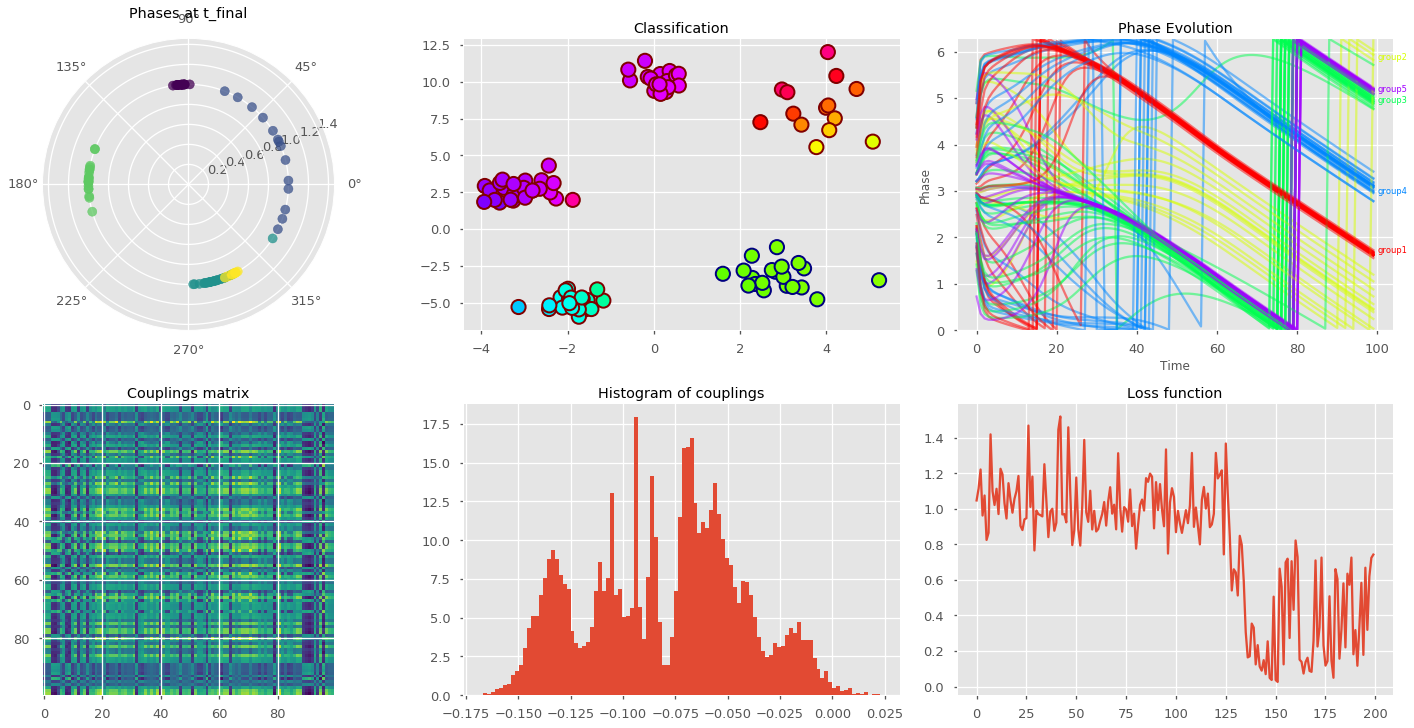

In [54]:
m=5
a = Trainer.batch
idx = Trainer.idx
masks = torch.FloatTensor(bs,m).zero_()
masks.scatter_(1,idx.unsqueeze(1).long(),1).transpose_(1,0)
ecolors = [cm.jet(x*10) for x in idx]
# init_phase = torch.normal(np.pi,1,(bs,)).float().unsqueeze(0)
init_phase = Trainer.init
#init_phase = torch.FloatTensor(bs,).uniform_(0, 2*np.pi).unsqueeze(0)
# Trainer.init_phase(bs)
phase, couplings  = Model(Trainer.init,a)


fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1])
ax.set_title('Classification')
ecolors = [cm.jet(x*10) for x in idx]
colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
ax.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)
ax = fig.add_subplot(spec4[1,0])
ax.set_title('Couplings matrix')
ax.imshow(couplings.detach().numpy())
#ax.colorbar()
#ax.set_axis('off')
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Histogram of couplings')
ax.hist(couplings.reshape(-1).detach().numpy(), 100, density=True)
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(Trainer.lh)
plt.savefig('circles classification',dpi=200)
plt.show()

# Moons 

In [37]:
num_seeds = 1
all_losses = []
all_init_phase = []
all_init_coupling = []
bs = 100

for seed in range(num_seeds):
    print(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    Model = Kuramoto_features(batch_size = bs, num_hid = 100,input_size=2, feature_size=10, device='cpu', adjoint=True,gain=1)
    gmm = Moons(noise = 0.05, random_state=1)
    #gmm = GMM(n_components=5, centroids=[[2,-2],[4,8],[-3,3],[-2,-5],[0,10]], cov_matrices=20*np.array([0.05*np.eye(2),0.02*np.diag([1,5]),0.02*np.eye(2),0.01*np.eye(2),0.01*np.eye(2)]))
#   gmm = GMM(n_components=2, centroids=[[2,-2],[-2,2]], cov_matrices=[0.5*np.eye(2),0.2*np.eye(2)])
#   gmm = GMM(n_components=3, centroids=[[2,-2],[4,4],[-3,3]], cov_matrices=[0.05*np.eye(2),0.02*np.diag([1,5]),.02*np.eye(2)])
    LossFunc = circular_moments_batch
    Trainer = KuraTrainer(Model, gmm, LossFunc=LossFunc, batch_size=bs)
    #all_init_coupling.append(Model.couplings.detach().clone().numpy())
    Trainer.train(gradient_steps=300,lr=7e-4,num_loss=0, burn_in_prop=.65, verbose=1)
    all_init_phase.append(Trainer.init)
    all_losses.append(Trainer.lh[-1])

0
Step: 0. Loss: (tensor(0.8362, grad_fn=<MeanBackward0>), tensor(0.8362, grad_fn=<MeanBackward0>), tensor(1.3887e-08, grad_fn=<MeanBackward0>))\n
Gradient norm: 38.04298400878906
Step: 10. Loss: (tensor(0.9031, grad_fn=<MeanBackward0>), tensor(0.9031, grad_fn=<MeanBackward0>), tensor(4.9878e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 72.44661712646484
Step: 20. Loss: (tensor(0.4512, grad_fn=<MeanBackward0>), tensor(0.4512, grad_fn=<MeanBackward0>), tensor(9.5708e-06, grad_fn=<MeanBackward0>))\n
Gradient norm: 11.836333274841309
Step: 30. Loss: (tensor(0.4498, grad_fn=<MeanBackward0>), tensor(0.4497, grad_fn=<MeanBackward0>), tensor(1.1469e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 41.883819580078125
Step: 40. Loss: (tensor(0.4096, grad_fn=<MeanBackward0>), tensor(0.4096, grad_fn=<MeanBackward0>), tensor(8.1694e-07, grad_fn=<MeanBackward0>))\n
Gradient norm: 11.089434623718262
Step: 50. Loss: (tensor(0.3289, grad_fn=<MeanBackward0>), tensor(0.3288, grad_fn=<MeanBackward0>), te

In [39]:
Trainer.train(gradient_steps=100,lr=7e-4,num_loss=0, burn_in_prop=.65, verbose=1)

Step: 0. Loss: (tensor(0.2293, grad_fn=<MeanBackward0>), tensor(0.2292, grad_fn=<MeanBackward0>), tensor(5.5667e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 212.15237426757812
Step: 10. Loss: (tensor(0.2437, grad_fn=<MeanBackward0>), tensor(0.2437, grad_fn=<MeanBackward0>), tensor(5.4691e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 54.45671081542969
Step: 20. Loss: (tensor(0.1923, grad_fn=<MeanBackward0>), tensor(0.1923, grad_fn=<MeanBackward0>), tensor(3.0399e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 13.922127723693848
Step: 30. Loss: (tensor(0.2017, grad_fn=<MeanBackward0>), tensor(0.2016, grad_fn=<MeanBackward0>), tensor(8.0383e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 4.101663589477539
Step: 40. Loss: (tensor(0.1885, grad_fn=<MeanBackward0>), tensor(0.1884, grad_fn=<MeanBackward0>), tensor(8.3244e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 0.8620786070823669
Step: 50. Loss: (tensor(0.1823, grad_fn=<MeanBackward0>), tensor(0.1822, grad_fn=<MeanBackward0>), tens

In [41]:
Trainer.train(gradient_steps=100,lr=7e-4,num_loss=0, burn_in_prop=.65, verbose=1)

Step: 0. Loss: (tensor(0.1570, grad_fn=<MeanBackward0>), tensor(0.1570, grad_fn=<MeanBackward0>), tensor(2.6256e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 0.7859864830970764
Step: 10. Loss: (tensor(0.1586, grad_fn=<MeanBackward0>), tensor(0.1586, grad_fn=<MeanBackward0>), tensor(5.8553e-06, grad_fn=<MeanBackward0>))\n
Gradient norm: 2.659668445587158
Step: 20. Loss: (tensor(0.1570, grad_fn=<MeanBackward0>), tensor(0.1570, grad_fn=<MeanBackward0>), tensor(2.1108e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 3.171858787536621
Step: 30. Loss: (tensor(0.1489, grad_fn=<MeanBackward0>), tensor(0.1489, grad_fn=<MeanBackward0>), tensor(1.7411e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 604.9522705078125
Step: 40. Loss: (tensor(0.1372, grad_fn=<MeanBackward0>), tensor(0.1371, grad_fn=<MeanBackward0>), tensor(0.0001, grad_fn=<MeanBackward0>))\n
Gradient norm: 1.9727884531021118
Step: 50. Loss: (tensor(0.1113, grad_fn=<MeanBackward0>), tensor(0.1113, grad_fn=<MeanBackward0>), tensor(5.

In [43]:
Trainer.train(gradient_steps=100,lr=7e-4,num_loss=0, burn_in_prop=.65, verbose=1)

Step: 0. Loss: (tensor(0.2211, grad_fn=<MeanBackward0>), tensor(0.2211, grad_fn=<MeanBackward0>), tensor(1.2838e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 25.40691375732422
Step: 10. Loss: (tensor(0.1106, grad_fn=<MeanBackward0>), tensor(0.1106, grad_fn=<MeanBackward0>), tensor(2.6116e-06, grad_fn=<MeanBackward0>))\n
Gradient norm: 5.020127296447754
Step: 20. Loss: (tensor(0.1150, grad_fn=<MeanBackward0>), tensor(0.1149, grad_fn=<MeanBackward0>), tensor(5.5639e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 2.824878454208374
Step: 30. Loss: (tensor(0.0910, grad_fn=<MeanBackward0>), tensor(0.0910, grad_fn=<MeanBackward0>), tensor(3.1603e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 4.075207710266113
Step: 40. Loss: (tensor(0.0896, grad_fn=<MeanBackward0>), tensor(0.0896, grad_fn=<MeanBackward0>), tensor(1.8710e-06, grad_fn=<MeanBackward0>))\n
Gradient norm: 1.0633769035339355
Step: 50. Loss: (tensor(0.0899, grad_fn=<MeanBackward0>), tensor(0.0899, grad_fn=<MeanBackward0>), tensor

In [45]:
Trainer.train(gradient_steps=100,lr=7e-4,num_loss=0, burn_in_prop=.65, verbose=1)

Step: 0. Loss: (tensor(0.1065, grad_fn=<MeanBackward0>), tensor(0.1065, grad_fn=<MeanBackward0>), tensor(4.8050e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 1.1483999490737915
Step: 10. Loss: (tensor(0.0781, grad_fn=<MeanBackward0>), tensor(0.0778, grad_fn=<MeanBackward0>), tensor(0.0003, grad_fn=<MeanBackward0>))\n
Gradient norm: 39.98293685913086
Step: 20. Loss: (tensor(0.0354, grad_fn=<MeanBackward0>), tensor(0.0354, grad_fn=<MeanBackward0>), tensor(1.2950e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 2.874006509780884
Step: 30. Loss: (tensor(0.0336, grad_fn=<MeanBackward0>), tensor(0.0335, grad_fn=<MeanBackward0>), tensor(0.0001, grad_fn=<MeanBackward0>))\n
Gradient norm: 1.5054529905319214
Step: 40. Loss: (tensor(0.0356, grad_fn=<MeanBackward0>), tensor(0.0354, grad_fn=<MeanBackward0>), tensor(0.0002, grad_fn=<MeanBackward0>))\n
Gradient norm: 5.80825662612915
Step: 50. Loss: (tensor(0.0155, grad_fn=<MeanBackward0>), tensor(0.0154, grad_fn=<MeanBackward0>), tensor(6.9439e-05,

In [47]:
Trainer.train(gradient_steps=100,lr=7e-4,num_loss=0, burn_in_prop=.65, verbose=1)

Step: 0. Loss: (tensor(0.0199, grad_fn=<MeanBackward0>), tensor(0.0199, grad_fn=<MeanBackward0>), tensor(2.6568e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 4.356255054473877
Step: 10. Loss: (tensor(0.0052, grad_fn=<MeanBackward0>), tensor(0.0052, grad_fn=<MeanBackward0>), tensor(6.5070e-06, grad_fn=<MeanBackward0>))\n
Gradient norm: 0.527628481388092
Step: 20. Loss: (tensor(6.7128e-05, grad_fn=<MeanBackward0>), tensor(6.7033e-05, grad_fn=<MeanBackward0>), tensor(9.4770e-08, grad_fn=<MeanBackward0>))\n
Gradient norm: 7.620980613864958e-05
Step: 30. Loss: (tensor(0.0204, grad_fn=<MeanBackward0>), tensor(0.0204, grad_fn=<MeanBackward0>), tensor(4.6042e-07, grad_fn=<MeanBackward0>))\n
Gradient norm: 0.013417226262390614
Step: 40. Loss: (tensor(0.0322, grad_fn=<MeanBackward0>), tensor(0.0322, grad_fn=<MeanBackward0>), tensor(1.2346e-05, grad_fn=<MeanBackward0>))\n
Gradient norm: 2.2026937007904053
Step: 50. Loss: (tensor(0.0306, grad_fn=<MeanBackward0>), tensor(0.0306, grad_fn=<MeanBack

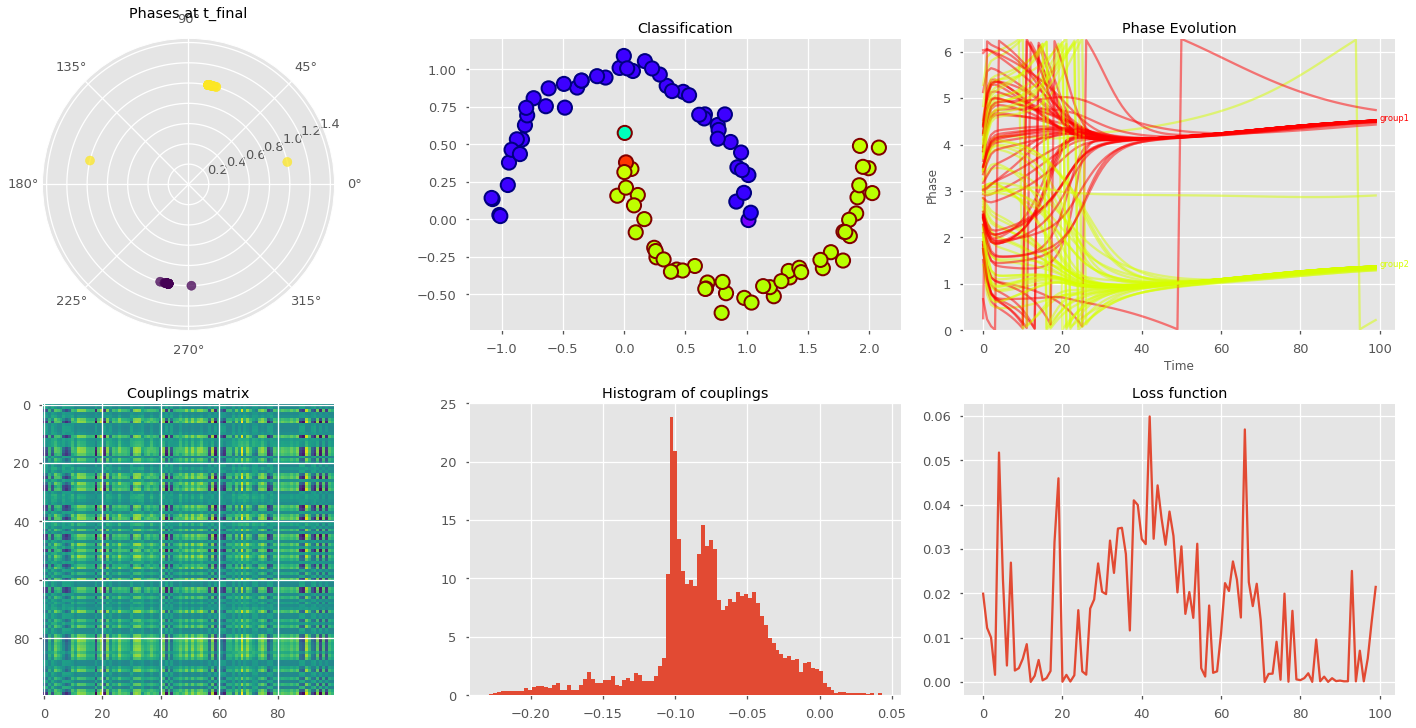

In [48]:
a = Trainer.batch
idx = Trainer.idx
masks = torch.FloatTensor(bs,m).zero_()
masks.scatter_(1,idx.unsqueeze(1).long(),1).transpose_(1,0)
ecolors = [cm.jet(x*10) for x in idx]
# init_phase = torch.normal(np.pi,1,(bs,)).float().unsqueeze(0)
init_phase = Trainer.init
#init_phase = torch.FloatTensor(bs,).uniform_(0, 2*np.pi).unsqueeze(0)
# Trainer.init_phase(bs)
phase, couplings  = Model(Trainer.init,a)


fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1])
ax.set_title('Classification')
ecolors = [cm.jet(x*10) for x in idx]
colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
ax.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)
ax = fig.add_subplot(spec4[1,0])
ax.set_title('Couplings matrix')
ax.imshow(couplings.detach().numpy())
#ax.colorbar()
#ax.set_axis('off')
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Histogram of couplings')
ax.hist(couplings.reshape(-1).detach().numpy(), 100, density=True)
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(Trainer.lh)
plt.savefig('circles classification',dpi=200)
plt.show()

### Feedback network

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('ggplot')
import torch
from torch.nn.functional import softmax
from scipy.special import softmax as np_softmax
from scipy.linalg import toeplitz, circulant
import numpy as np
from torch.autograd import Variable
from torch.distributions import uniform, cauchy, normal, relaxed_bernoulli
import matplotlib.animation as animation
from IPython.display import HTML
import time
import ipdb

In [5]:
def update_gif(i, im, data):
    im.set_array(data[i])
    return im

def show_connectivities_gif(connectivities):
    im = plt.imshow(connectivities[0], animated=True)
    ani = animation.FuncAnimation(fig, update_gif, fargs=(im, connectivities))
    plt.show(block=False)

In [6]:
def sigmoid(x):
    return 1. / (1 + torch.exp(-1*(x)))

def normalize(x):
    return x / torch.sqrt((x**2).sum())

In [7]:
def make_connectivity(soft_connectivity):
    batch_size = soft_connectivity.shape[0]
    ut_size = soft_connectivity.shape[-1]
    num_units = int(.5*(np.sqrt(8*ut_size + 1) + 1))
    triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)

    connectivity = torch.zeros((batch_size, num_units, num_units))
    _, hard_inds = torch.topk(soft_connectivity,num_links, dim=-1)
    hard_connectivity = torch.zeros_like(soft_connectivity).scatter_(1,hard_inds, torch.ones_like(hard_inds).float())
    ut_connectivity = hard_connectivity - soft_connectivity.detach() + soft_connectivity

    connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
    connectivity += connectivity.transpose(2,1)
    return connectivity

In [8]:
def get_dist(dist_name,):
    if dist_name == 'cauchy':
        loc = 0.0
        scale = 1.0
        dist = cauchy.Cauchy(loc, scale)
        g0 = torch.exp(dist.log_prob(loc))
        return dist, g0
    elif dist_name == 'uniform':
        high = 1.0
        low = -1.0
        g0 = 1. / (high - low)
        dist = uniform.Uniform(-1.0, 1.0)
        return dist, g0

In [9]:
def get_current_lr(optimizer):
    # Adam has different learning rates for each paramter. So we need to pick the
    # group and paramter first.
    lrs = []
    for group in optimizer.param_groups:
        for p in group['params']:
            beta1, _ = group['betas']
            state = optimizer.state[p]

            bias_correction1 = 1 - beta1 ** state['step']
            lrs.append(group['lr'] / bias_correction1)
    return lrs

In [10]:
# Loss functions and statistics

def circular_variance(phases):
    num_phases = phases.shape[-1]
    xx = torch.cos(phases)
    yy = torch.sin(phases)
    return (1 - (torch.sqrt(xx.sum(-1)**2 + yy.sum(-1)**2)) / num_phases).mean()

def c_omega(omega, connectivity):
    omega_bar = omega.mean(1).unsqueeze(1)
    num = (connectivity * torch.einsum('bi,bj->bij',(omega - omega_bar) ,(omega - omega_bar) )).sum((1,2))
    den = (connectivity * (omega - omega_bar).unsqueeze(1)**2).sum((1,2))
    return (num / den + 1e-6).mean()

def laplacian(connectivity,sym_norm=True):
    A = connectivity
    D = torch.diag_embed(A.sum(1))
    D_mask = torch.diag_embed(torch.ones_like(A.sum(1)))
    L = D-A
    D2neg = torch.where(D_mask.bool(), D**(-.5),torch.zeros_like(D))
    D2 = torch.where(D_mask.bool(), D**(.5),torch.zeros_like(D))
    D2neg = torch.where(torch.isinf(D2neg), torch.zeros_like(D2neg),D2neg)
    if sym_norm:
        return torch.bmm(D2neg,torch.bmm(L,D2))
    else:
        return L

def p_neg(omega, connectivity):
    num_units = omega.shape[1]
#     num_ut = int(num_units * (num_units - 1) / 2)
    sign_omega = torch.sign(omega)
    sign_prods = torch.einsum('bi,bj->bij',sign_omega, sign_omega)
    num_links= (connectivity > 0).sum((1,2))
    opp_connections = (sign_prods * connectivity) < 0
    return ((opp_connections.sum((1,2))) / num_links.float()).mean()

def omega_energy(omega, connectivity):
    L = laplacian(connectivity)
    return -1*torch.einsum('bi,bi->b', omega, torch.einsum('bij,bi->bj',L, omega)).mean()

In [11]:
def run_kuramoto(coupling, omega, alpha=.1, steps=100, phase_init=None, burn_in_prop=.5):
    num_units = coupling.shape[2]
    burn_in_steps = int(burn_in_prop * steps)
    
    if phase_init == None:
        phase = np.pi*torch.ones((1,num_units))
    else:
        phase = phase_init
    flow = []
    for i in range(steps):
        phase = kuramoto_step(phase,coupling,omega,alpha=alpha)
        flow.append(phase)
    flow = torch.stack(flow).transpose(1,0)
    truncated_flow = flow[:,burn_in_steps:,:]
    cv = circular_variance(truncated_flow).detach().numpy()
    return cv, flow.detach().numpy()

def kuramoto_step(phase, coupling, omega, alpha=.01):
    phase_diffs = torch.sin(phase.unsqueeze(-1) - phase.unsqueeze(-2))
    delta = alpha * (omega + (coupling * phase_diffs).sum(1))
    return phase + delta

def kuramoto_step_(phase, coupling, omega, alpha=.5):
    phase = phase.reshape(coupling.shape[0],-1).float()
    n = coupling.shape[0]
    delta_phase = (coupling.unsqueeze(0)@torch.sin(phase).float() * torch.cos(phase) - 
    coupling.unsqueeze(0)@torch.cos(phase).float() * torch.sin(phase)) / n 
    return phase + alpha*delta_phase

In [12]:
# Networks

# Predict connectivity from omega
class connectivity_net(torch.nn.Module):
    def __init__(self, num_in, num_out, num_hid_units=256, num_hid_layers=1,transform=None,gain=1.):
        super(connectivity_net, self).__init__()
        self.transform=transform
        self.num_out = num_out
        self.gain = gain
        self.layers = torch.nn.ModuleList([torch.nn.Linear(num_in, num_hid_units),
                         torch.nn.ReLU()])
        for _ in range(num_hid_layers):
            self.layers.extend([torch.nn.Linear(num_hid_units, num_hid_units),torch.nn.ReLU()])
        self.layers.append(torch.nn.Linear(num_hid_units,self.num_out))
        
        for layer in self.layers:
            try :
                #torch.nn.init.orthogonal_(layer.weight, gain=1)
                #torch.nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='tanh')
                torch.nn.init.xavier_normal_(layer.weight, gain=self.gain)
                #torch.nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='tanh')
            except:
                pass
            
    def forward(self,x):   
        for layer in self.layers:
            x = layer(x)
        if self.transform == 'softmax':
            x = softmax(x,dim=-1)
        elif self.transform == 'sigmoid':
            x = sigmoid(x)   
        #else:
        #    x = x/torch.pow(x,2).sum(-1).unsqueeze(1)
        return x

In [40]:
class KuraTrainerfeedback(object):
    
    def __init__(self, model, data_generator, LossFunc, num_out,
                          transform=None,kuramoto_steps=100, lr=.01, alpha=.1,
                          hidden_size =128, num_hid_layers=1,batch_size=256,optimizer='Adam',init_std=0.5,
                          view_connectivities=-1, feedback='full', verbose=0):
        
        super(KuraTrainerfeedback, self).__init__()
        self.data_generator = data_generator
        self.batch_size = batch_size
        self.LossFunc = LossFunc
        self.model = model
        self.verbose = verbose
        self.in_size = 100
        self.hidden_size = hidden_size 
        self.num_layers = num_hid_layers
        self.num_out = self.batch_size * self.batch_size
        self.transform=None
        self.kuramoto_steps=kuramoto_steps
        self.lr=lr
        self.alpha= alpha
        self.num_hid_layers=1,
        self.init_std = init_std
        
        self.GRU = (type(model) == KuraGRU)
        self.feedback = feedback

        #model and optimizer
        self.model = model
        if optimizer=='Adam':
            self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        elif optimizer=='SGD':
            self.opt = torch.optim.SGD(self.model.parameters(), lr=lr)
                
    def init_phase(self,batch_size):
        self.init = torch.normal(np.pi,self.init_std,(batch_size,)).float().unsqueeze(0)
        return self.init
     
    def kuramoto_step(self, phase, coupling, omega):
        phase_diffs = torch.sin(phase.unsqueeze(-1) - phase.unsqueeze(-2))
        delta = self.alpha * (omega + (coupling * phase_diffs).sum(1))
        return phase + delta
    
    #def kuramoto_step_(self, phase, coupling, omega):
    #    phase = phase.reshape(coupling.shape[0],-1).float()
    #    n = coupling.shape[0]
    #    delta_phase = (coupling.unsqueeze(0)@torch.sin(phase).float() * torch.cos(phase) - 
    #    coupling.unsqueeze(0)@torch.cos(phase).float() * torch.sin(phase)) / n 
    #    return phase + self.alpha*delta_phase
                
    def train(self,gradient_steps=50, lr=0.1, normalized=False, eps=1e-12, num_loss=0, burn_in_prop=.5, omega_bool=False):
        
            self.losses = []
            self.init_phase(self.batch_size)
            
            with torch.no_grad():
                batch, idx = self.data_generator.sample(self.batch_size)
                self.batch = batch.float()
                self.idx = idx.float()
                self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
                self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
                if omega_bool == False:
                    omega = torch.zeros((self.batch_size,)).float()
                else:
                    omega = torch.FloatTensor((self.batch_size,)).uniform_(0,1)
            
            for i in range(gradient_steps):
                
                start = time.time()
                self.phase_trajectory = []
                self.couplings = []
                    
                #Initial parameters
                self.init_phase(self.batch_size)
                phase = self.init
                self.phase_trajectory.append(phase)
                
                if self.feedback == 'full':
                    for j in range(self.kuramoto_steps):
                    #for j in range(np.random.randint(low=50, high=150)):

                        #Update functions
                        #x_in = torch.cat([self.batch.reshape(1,-1),phase],1)
                        out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                        phase = self.kuramoto_step(phase, out, omega)
                        #Bookkeeping
                        self.phase_trajectory.append(phase)      
                        self.couplings.append(out) 
                elif self.feedback in ['perturbation',False]:
                    out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                    for j in range(self.kuramoto_steps):
                        phase = self.kuramoto_step(phase, out, omega)
                        #Bookkeeping
                        self.phase_trajectory.append(phase)      
                        self.couplings.append(out) 
                    
                flow = torch.stack(self.couplings).detach()
                phases = torch.stack(self.phase_trajectory)
                
                #Loss computation
                loss = self.LossFunc(phases,self.masks,split=True, burn_in_prop=burn_in_prop)
                loss[num_loss].backward()
                self.phases = phases.detach()
                self.losses.append(loss[num_loss].detach().cpu().numpy())
                self.opt.step()
                self.opt.zero_grad()
                stop = time.time()
                
                if self.verbose:
                    print('Iteration {}. Loss: {}. Time/flow: {}'.format(i, self.losses[-1], stop-start))

                #if cv != cv:
                #    ipdb.set_trace()

            return self.losses
        
    def run(self,kuramoto_steps=50, normalized=False,num_loss=0,burn_in_prop=.5):

        start = time.time()
        self.phase_trajectory = []
        self.couplings = []
        #with torch.no_grad():
        #    batch, idx = self.data_generator.sample(self.batch_size)
        #    self.batch = batch.float()
        #    self.idx = idx.float()
        #    self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
        #    self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)

        #Initial parameters
        self.init_phase(self.batch_size)
        phase = self.init  
        omega = torch.zeros_like(phase)
        self.phase_trajectory.append(phase)

        if self.feedback == 'full':
            for j in range(kuramoto_steps):
            #for j in range(np.random.randint(low=50, high=150)):

                #Update functions
                #x_in = torch.cat([self.batch.reshape(1,-1),phase],1)
                out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback in ['perturbation',False]:
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
            

        self.flow = torch.stack(self.couplings).detach()
        self.phases = torch.stack(self.phase_trajectory).detach()

        #Loss computation
        loss = self.LossFunc(self.phases,self.masks,split=True, burn_in_prop=burn_in_prop)
        self.losses.append(loss[num_loss].detach().cpu().numpy())
        stop = time.time()
        
        return self.losses
    """        
    def train_GRU(self, gradient_steps=50, lr=0.1, normalized=False, eps=1e-12,num_loss=0,burn_in_prop=.5):

        self.losses = []
        self.init_phase(self.batch_size)

        with torch.no_grad():
            batch, idx = self.data_generator.sample(self.batch_size)
            self.batch = batch.float()
            self.idx = idx.float()
            self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
            self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
            

        for i in range(gradient_steps):

            start = time.time()
            self.phase_trajectory = []
            self.couplings = []
            self.hiddens = []

            #Initial parameters
            if self.GRU:
                h = self.model.init_hidden(self.batch_size)
                
            phase = self.init
            omega = torch.zeros_like(phase)
            self.phase_trajectory.append(phase)

            #for j in range(np.random.randint(low=50, high=150)):
            for j in range(kuramoto_steps):

                #Update functions
                #x_in = torch.cat([self.batch.reshape(1,-1),phase],1)
                
                if self.GRU:
                    out, h = self.model(omega, h, phase)  #GRU changing
                    out = out.reshape(1,self.batch_size,self.batch_size)
                    phase = self.kuramoto_step(phase, out, omega)
                    self.hiddens.append(h) 
                else:
                    out = self.model(phase).reshape(1,batch_size,batch_size)
                    phase = self.kuramoto_step(phase, out, omega)
                    
                
                #Bookkeeping
                
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 

            flow = torch.stack(self.couplings).detach()
            phases = torch.stack(self.phase_trajectory)
            hiddens = torch.stack(self.hiddens)

            #Loss computation
            loss = self.LossFunc(phases,self.masks,split=True, burn_in_prop=burn_in_prop)
            loss[num_loss].backward()
            self.phases = phases.detach()
            self.losses.append(loss[num_loss].detach().cpu().numpy())
            self.opt.step()
            self.opt.zero_grad()
            stop = time.time()

            if self.verbose:
                print('Iteration {}. Loss: {}. Time/flow: {}'.format(i, self.losses[-1], stop-start))

        return self.losses
    
    """
    
    def run_perturbation(self,perturbations,kuramoto_steps=50,num_loss=0):

        start = time.time()
        self.phase_trajectory = []
        self.couplings = []
        #with torch.no_grad():
        #    batch, idx = self.data_generator.sample(self.batch_size)
        #    self.batch = batch.float()
        #    self.idx = idx.float()
        #    self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
        #    self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)

        #Initial parameters
        self.init_phase(self.batch_size)
        phase = self.init  
        omega = torch.zeros_like(phase)
        self.phase_trajectory.append(phase)

        
        if self.feedback:
            for j in range(kuramoto_steps):
            #for j in range(np.random.randint(low=50, high=150)):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]

                #Update functions
                #x_in = torch.cat([self.batch.reshape(1,-1),phase],1)
                out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback == 'perturbation':
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]
                    out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                        
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback == False:
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]
                        
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 


        self.flow = torch.stack(self.couplings).detach()
        self.phases = torch.stack(self.phase_trajectory).detach()

        #Loss computation
        loss = self.LossFunc(self.phases,self.masks,split=True, burn_in_prop=.19)
        self.losses.append(loss[num_loss].detach().cpu().numpy())
        stop = time.time()
        

        return self.losses

In [14]:
# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
batch_size=50
transform='softmax'
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 100
alpha = 0.1
lr=1e-4
optimizer='Adam'



num_in = batch_size #+ 2*batch_size
hidden_size = 100
num_out = batch_size*batch_size

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=1,transform=None,gain=0.5)
data_generator = GMM(n_components=5, centroids=[[2,-2],[4,4],[-3,3],[-2,-5],[0,10]], cov_matrices=[0.05*np.eye(2),0.02*np.diag([1,5]),0.02*np.eye(2),0.01*np.eye(2),0.01*np.eye(2)])
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=batch_size,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1)

losses = Trainer.train(gradient_steps = 600,num_loss=0, burn_in_prop=0.99)

NameError: name 'KuraGRU' is not defined

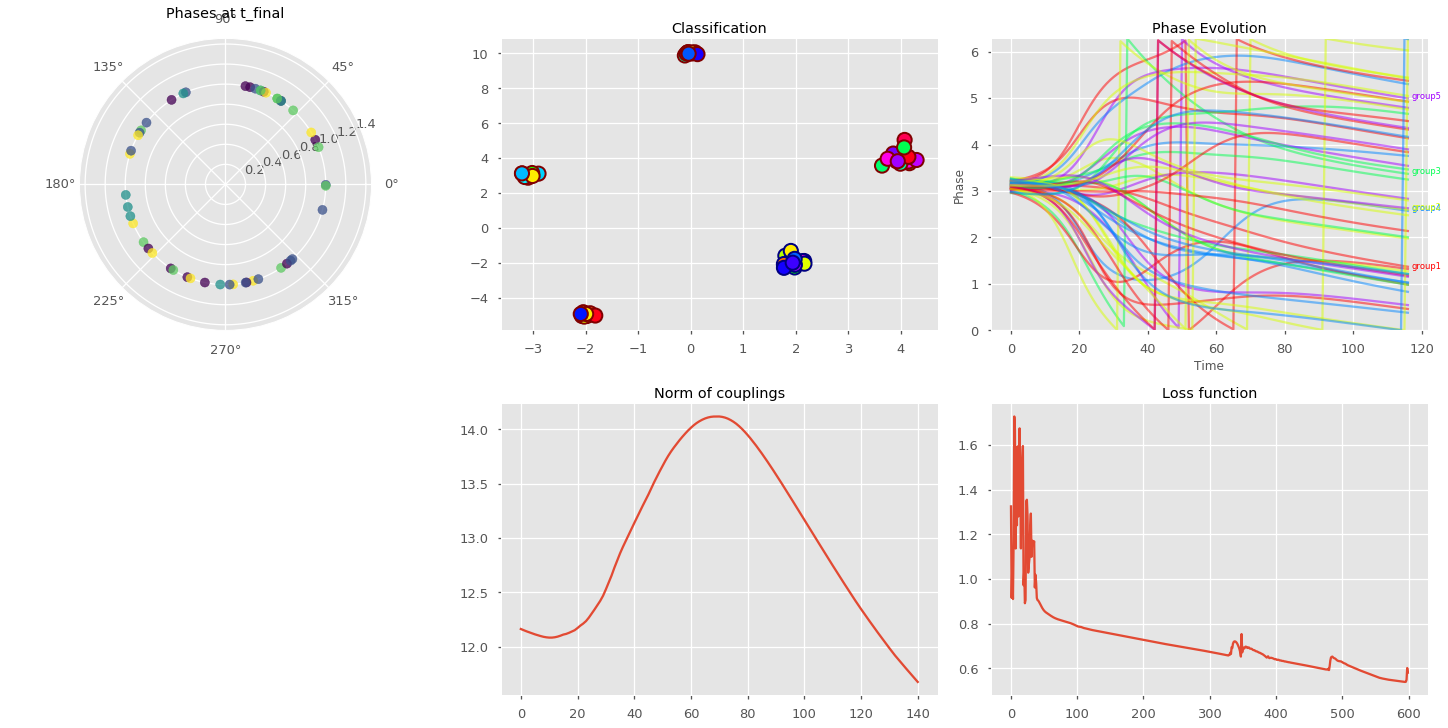

In [66]:
init_phase = Trainer.init
a = Trainer.batch
idx = Trainer.idx
phase = Trainer.phases
couplings = torch.stack(Trainer.couplings).reshape(141,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1])
ax.set_title('Classification')
ecolors = [cm.jet(x*10) for x in idx]
colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
ax.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)
#ax = fig.add_subplot(spec4[1,0])
#ax.set_title('Couplings matrix')
#ax.imshow(couplings.detach().numpy())
#ax.colorbar()
#ax.set_axis('off')
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
ax.plot(torch.pow(couplings,2).sum((1,2)).detach().numpy())
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
plt.savefig('circles classification',dpi=200)
plt.show()

# N = 50, fixed init, random time window

In [138]:
Trainer.run(kuramoto_steps=300)

[array(1.3884293, dtype=float32),
 array(1.2615528, dtype=float32),
 array(1.6285753, dtype=float32),
 array(3.4718344, dtype=float32),
 array(0.9668691, dtype=float32),
 array(1.5159285, dtype=float32),
 array(2.456564, dtype=float32),
 array(1.5154847, dtype=float32),
 array(1.3543639, dtype=float32),
 array(1.2182331, dtype=float32),
 array(1.4705315, dtype=float32),
 array(1.3252828, dtype=float32),
 array(1.5824282, dtype=float32),
 array(1.035065, dtype=float32),
 array(1.0288078, dtype=float32),
 array(1.0937858, dtype=float32),
 array(0.91981894, dtype=float32),
 array(0.8286769, dtype=float32),
 array(0.8034136, dtype=float32),
 array(1.0003214, dtype=float32),
 array(1.4731238, dtype=float32),
 array(1.7343719, dtype=float32),
 array(1.0894425, dtype=float32),
 array(0.8753307, dtype=float32),
 array(1.2282528, dtype=float32),
 array(1.0349711, dtype=float32),
 array(1.231394, dtype=float32),
 array(1.1967103, dtype=float32),
 array(1.2304142, dtype=float32),
 array(1.1033691

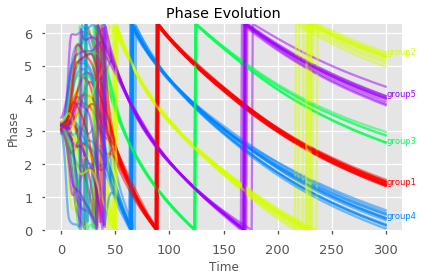

In [139]:
phase_evol(Trainer.phases,Trainer.masks.unsqueeze(0).data.numpy())

# More oscillators n = 200, fixed init, fixed time

In [41]:
#### Linear modeling

# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
batch_size=200
transform='softmax'
num_hid_units= 200
num_hid_layers = 1
kuramoto_steps= 50
alpha = 0.1
burn_in_steps = 75
lr=1e-4
optimizer='Adam'




num_in = batch_size + 2*batch_size
hidden_size = 100
num_out = batch_size*batch_size

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=1,transform=None)
data_generator = GMM(n_components=5, centroids=[[2,-2],[4,4],[-3,3],[-2,-5],[0,10]], cov_matrices=[0.05*np.eye(2),0.02*np.diag([1,5]),0.02*np.eye(2),0.01*np.eye(2),0.01*np.eye(2)])
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=batch_size,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          burn_in_steps=burn_in_steps,
                          optimizer=optimizer,
                          verbose=1)

losses = Trainer.train(gradient_steps = 500,num_loss=0, burn_in_prop=.65)

Iteration 0. Loss: 1.122946858406067. Time/flow: 4.042393207550049
Iteration 1. Loss: 1.1303101778030396. Time/flow: 3.766148090362549
Iteration 2. Loss: 1.4426735639572144. Time/flow: 3.945357084274292
Iteration 3. Loss: 1.1772254705429077. Time/flow: 4.039332389831543
Iteration 4. Loss: 1.4918683767318726. Time/flow: 4.424236297607422
Iteration 5. Loss: 1.1873303651809692. Time/flow: 4.550907135009766
Iteration 6. Loss: 2.056844472885132. Time/flow: 4.403984785079956
Iteration 7. Loss: 1.651921272277832. Time/flow: 3.2243595123291016
Iteration 8. Loss: 1.7306991815567017. Time/flow: 3.6397812366485596
Iteration 9. Loss: 1.2871848344802856. Time/flow: 3.9094178676605225
Iteration 10. Loss: 1.8485170602798462. Time/flow: 3.770218849182129
Iteration 11. Loss: 1.953938603401184. Time/flow: 4.24126410484314
Iteration 12. Loss: 1.790489673614502. Time/flow: 3.974397659301758
Iteration 13. Loss: 1.5655473470687866. Time/flow: 4.179206848144531
Iteration 14. Loss: 1.8135037422180176. Time/fl

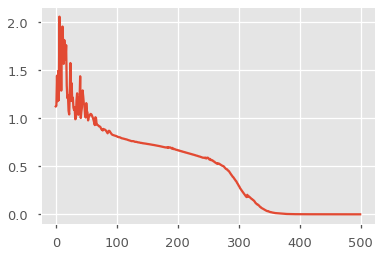

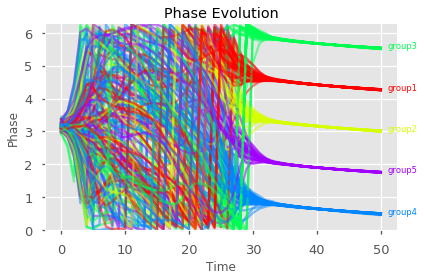

In [42]:
plt.plot(losses)
plt.show()
phase_evol(Trainer.phases,Trainer.masks.unsqueeze(0).data.numpy())

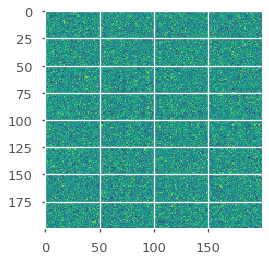

In [43]:
fig, ax = plt.subplots()
tmp_connectivities = torch.stack(Trainer.couplings)[:,0,...].detach().numpy()
im = plt.imshow(tmp_connectivities[0,...])
animate = lambda i: im.set_array(tmp_connectivities[i,...])
ani = animation.FuncAnimation(fig, animate, frames=kuramoto_steps)
HTML(ani.to_html5_video())

# GRU model

In [15]:
class KuraGRU(torch.nn.Module):
    def __init__(self, num_in, num_out, hidden_size, num_hid_units=256, num_layers=1, transform=None):
        super(KuraGRU, self).__init__()
        
        self.num_in=num_in
        self.num_out = num_out
        self.num_hid_units = num_hid_units
        self.num_layers = num_layers
        self.transform = transform
        
        #Model instanciation
        gru_in = 2*self.num_in
        self.gru = torch.nn.GRU(gru_in, num_hid_units, num_layers)
        self.fc = torch.nn.Linear(self.num_hid_units, self.num_out)
        self.relu = torch.nn.ReLU()
        
                
    def forward(self, omega, h, phase, alpha=1e-1, GRU_steps=10, kuramoto_steps=100):
     
        data = torch.cat([omega, phase], dim=-1).unsqueeze(0)
        out, h = self.gru(data,h)
        out = self.fc(self.relu(out.squeeze(0)))

        return out, h
        
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_layers, 1, self.num_hid_units).zero_()
        return hidden

In [19]:

# Training parameters
seed = 12
np.random.seed(seed)
torch.manual_seed(seed)
batch_size=50
transform='softmax'
num_hid_units= 100
num_hid_layers = 2
kuramoto_steps= 100
alpha = 0.2
lr=1e-4
optimizer='Adam'




num_in = batch_size #+ 2*batch_size
hidden_size = 100
num_out = batch_size*batch_size

model = KuraGRU(num_in, num_out, hidden_size, num_hid_units=num_hid_units, num_layers=num_hid_layers, transform=None)
data_generator = GMM(n_components=5, centroids=[[2,-2],[4,4],[-3,3],[-2,-5],[0,10]], cov_matrices=[0.05*np.eye(2),0.02*np.diag([1,5]),0.02*np.eye(2),0.01*np.eye(2),0.01*np.eye(2)])
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=batch_size,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1)

losses = Trainer.train_GRU(gradient_steps = 600,num_loss=0, burn_in_prop=0.99)

Iteration 0. Loss: 1.3248357772827148. Time/flow: 1.6995747089385986
Iteration 1. Loss: 0.9157607555389404. Time/flow: 1.9869015216827393
Iteration 2. Loss: 1.0620282888412476. Time/flow: 1.555635929107666
Iteration 3. Loss: 0.9104898571968079. Time/flow: 1.436852216720581
Iteration 4. Loss: 1.1727039813995361. Time/flow: 1.432699203491211
Iteration 5. Loss: 1.7270607948303223. Time/flow: 1.7789642810821533
Iteration 6. Loss: 1.6665523052215576. Time/flow: 1.6337018013000488
Iteration 7. Loss: 1.1365458965301514. Time/flow: 1.8835208415985107
Iteration 8. Loss: 1.3744323253631592. Time/flow: 1.9356958866119385
Iteration 9. Loss: 1.240336298942566. Time/flow: 1.6302144527435303
Iteration 10. Loss: 1.593389868736267. Time/flow: 1.7910759449005127
Iteration 11. Loss: 1.279678225517273. Time/flow: 1.4054298400878906
Iteration 12. Loss: 1.5438899993896484. Time/flow: 1.1971735954284668
Iteration 13. Loss: 1.6738548278808594. Time/flow: 1.6851129531860352
Iteration 14. Loss: 1.50071597099304

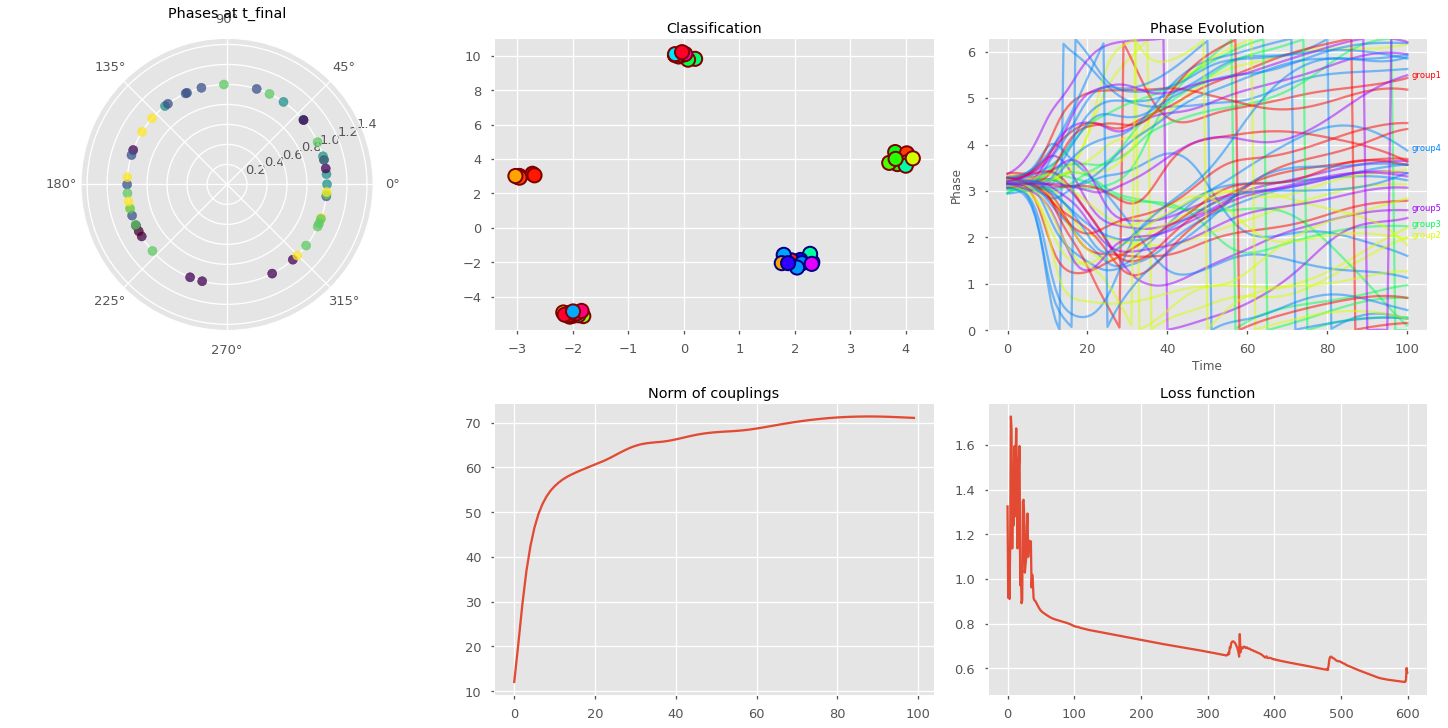

In [29]:
init_phase = Trainer.init
a = Trainer.batch
idx = Trainer.idx
phase = Trainer.phases
couplings = torch.stack(Trainer.couplings).reshape(100,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1])
ax.set_title('Classification')
ecolors = [cm.jet(x*10) for x in idx]
colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
ax.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)
#ax = fig.add_subplot(spec4[1,0])
#ax.set_title('Couplings matrix')
#ax.imshow(couplings.detach().numpy())
#ax.colorbar()
#ax.set_axis('off')
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
ax.plot(torch.pow(couplings,2).sum((1,2)).detach().numpy())
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
plt.savefig('circles classification',dpi=200)
plt.show()

# Fixed graph

In [18]:
# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=50
n_groups = 5
transform='softmax'
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 200
alpha = 0.1
lr=1e-4
optimizer='Adam'
init_std = 0.5



num_in = n_nodes #+ 2*batch_size
hidden_size = 100
num_out = n_nodes*n_nodes

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=None,gain=0.5)
data_generator = fixed_graph(n_nodes, n_groups)
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std)

losses = Trainer.train(gradient_steps = 1000,num_loss=0, burn_in_prop=0.99)

Iteration 0. Loss: 1.3147536516189575. Time/flow: 0.5972440242767334
Iteration 1. Loss: 1.0530158281326294. Time/flow: 0.453204870223999
Iteration 2. Loss: 1.7355809211730957. Time/flow: 0.40648341178894043
Iteration 3. Loss: 0.9957234263420105. Time/flow: 0.5106518268585205
Iteration 4. Loss: 1.5990567207336426. Time/flow: 0.4988062381744385
Iteration 5. Loss: 1.0867094993591309. Time/flow: 0.5682618618011475
Iteration 6. Loss: 0.829071044921875. Time/flow: 0.48038816452026367
Iteration 7. Loss: 1.6035822629928589. Time/flow: 0.48096632957458496
Iteration 8. Loss: 0.9301647543907166. Time/flow: 0.4081151485443115
Iteration 9. Loss: 0.8931694030761719. Time/flow: 0.5195870399475098
Iteration 10. Loss: 1.175704002380371. Time/flow: 0.4263145923614502
Iteration 11. Loss: 1.0847762823104858. Time/flow: 0.4698479175567627
Iteration 12. Loss: 1.1294336318969727. Time/flow: 0.5412471294403076
Iteration 13. Loss: 1.0507793426513672. Time/flow: 0.4107692241668701
Iteration 14. Loss: 1.40719652

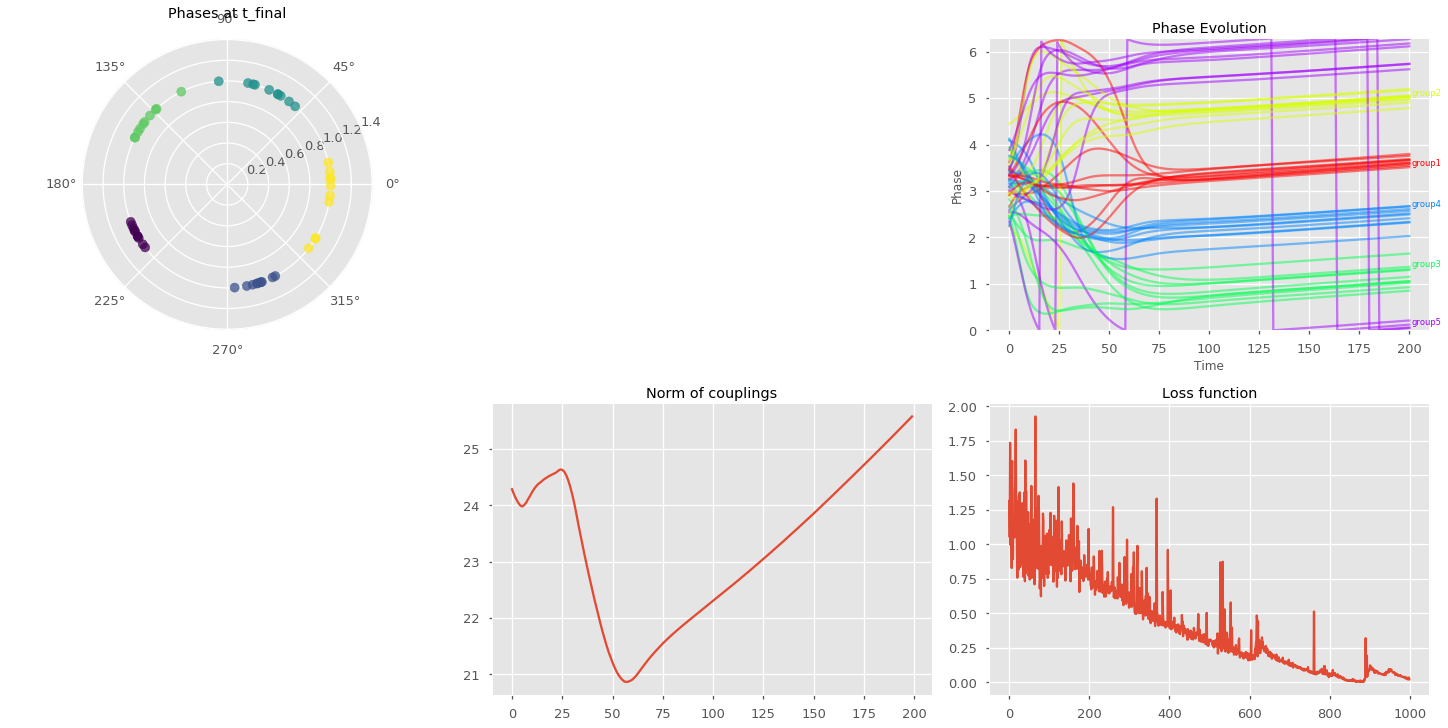

In [19]:
init_phase = Trainer.init
a = Trainer.batch
idx = Trainer.idx
phase = Trainer.phases
couplings = torch.stack(Trainer.couplings).reshape(200,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
#ax = fig.add_subplot(spec4[0, 1])
#ax.set_title('Classification')
#ecolors = [cm.jet(x*10) for x in idx]
#colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
#ax.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)
#ax = fig.add_subplot(spec4[1,0])
#ax.set_title('Couplings matrix')
#ax.imshow(couplings.detach().numpy())
#ax.colorbar()
#ax.set_axis('off')
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
ax.plot(torch.pow(couplings,2).sum((1,2)).detach().numpy())
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
plt.savefig('circles classification',dpi=200)
plt.show()

In [84]:
Trainer.run(kuramoto_steps=300)

[array(1.6392871, dtype=float32),
 array(1.688895, dtype=float32),
 array(1.9494283, dtype=float32),
 array(1.6270282, dtype=float32),
 array(1.4059421, dtype=float32),
 array(1.1740716, dtype=float32),
 array(1.4471776, dtype=float32),
 array(1.1303016, dtype=float32),
 array(1.4095159, dtype=float32),
 array(0.811983, dtype=float32),
 array(1.743165, dtype=float32),
 array(0.63332355, dtype=float32),
 array(0.64890414, dtype=float32),
 array(0.80931365, dtype=float32),
 array(1.2797987, dtype=float32),
 array(0.8233231, dtype=float32),
 array(0.66962886, dtype=float32),
 array(0.7596867, dtype=float32),
 array(0.5986575, dtype=float32),
 array(0.8410912, dtype=float32),
 array(0.6815103, dtype=float32),
 array(0.7222979, dtype=float32),
 array(0.65296304, dtype=float32),
 array(0.81285, dtype=float32),
 array(0.6970766, dtype=float32),
 array(0.68987006, dtype=float32),
 array(0.7832004, dtype=float32),
 array(0.5184438, dtype=float32),
 array(0.78582776, dtype=float32),
 array(0.721

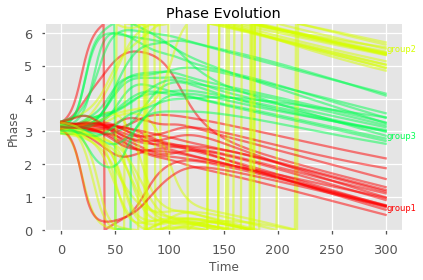

In [85]:
phase_evol(Trainer.phases,Trainer.masks.unsqueeze(0).data.numpy())

In [25]:
Trainer.init_std = 0.5
Trainer.run(kuramoto_steps=600)

[array(1.3147537, dtype=float32),
 array(1.0530158, dtype=float32),
 array(1.7355809, dtype=float32),
 array(0.9957234, dtype=float32),
 array(1.5990567, dtype=float32),
 array(1.0867095, dtype=float32),
 array(0.82907104, dtype=float32),
 array(1.6035823, dtype=float32),
 array(0.93016475, dtype=float32),
 array(0.8931694, dtype=float32),
 array(1.175704, dtype=float32),
 array(1.0847763, dtype=float32),
 array(1.1294336, dtype=float32),
 array(1.0507793, dtype=float32),
 array(1.4071965, dtype=float32),
 array(1.4264121, dtype=float32),
 array(1.8317089, dtype=float32),
 array(1.2126554, dtype=float32),
 array(1.3141396, dtype=float32),
 array(0.9586509, dtype=float32),
 array(0.7589889, dtype=float32),
 array(1.2332859, dtype=float32),
 array(0.9858107, dtype=float32),
 array(0.8173668, dtype=float32),
 array(1.3521175, dtype=float32),
 array(1.2446847, dtype=float32),
 array(1.3767008, dtype=float32),
 array(0.8357236, dtype=float32),
 array(0.8531373, dtype=float32),
 array(0.9667

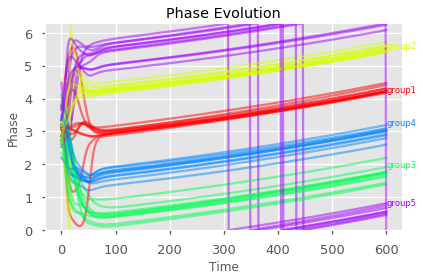

In [26]:
phase_evol(Trainer.phases,Trainer.masks.unsqueeze(0).data.numpy())

In [31]:
#Trainer.init_std = 3
perturbation = dict(zip([500,1000,1500],[torch.normal(0,1,(50,)).float().unsqueeze(0),torch.normal(0,1,(50,)).float().unsqueeze(0),torch.normal(0,1,(50,)).float().unsqueeze(0)]))
#perturbation = zip([(150,400),(torch.normal(np.pi,1,(batch_size,)).float().unsqueeze(0),torch.normal(np.pi,1,(batch_size,)).float().unsqueeze(0))])
Trainer.run_perturbation(perturbations=perturbation,kuramoto_steps=2000)

[array(1.3147537, dtype=float32),
 array(1.0530158, dtype=float32),
 array(1.7355809, dtype=float32),
 array(0.9957234, dtype=float32),
 array(1.5990567, dtype=float32),
 array(1.0867095, dtype=float32),
 array(0.82907104, dtype=float32),
 array(1.6035823, dtype=float32),
 array(0.93016475, dtype=float32),
 array(0.8931694, dtype=float32),
 array(1.175704, dtype=float32),
 array(1.0847763, dtype=float32),
 array(1.1294336, dtype=float32),
 array(1.0507793, dtype=float32),
 array(1.4071965, dtype=float32),
 array(1.4264121, dtype=float32),
 array(1.8317089, dtype=float32),
 array(1.2126554, dtype=float32),
 array(1.3141396, dtype=float32),
 array(0.9586509, dtype=float32),
 array(0.7589889, dtype=float32),
 array(1.2332859, dtype=float32),
 array(0.9858107, dtype=float32),
 array(0.8173668, dtype=float32),
 array(1.3521175, dtype=float32),
 array(1.2446847, dtype=float32),
 array(1.3767008, dtype=float32),
 array(0.8357236, dtype=float32),
 array(0.8531373, dtype=float32),
 array(0.9667

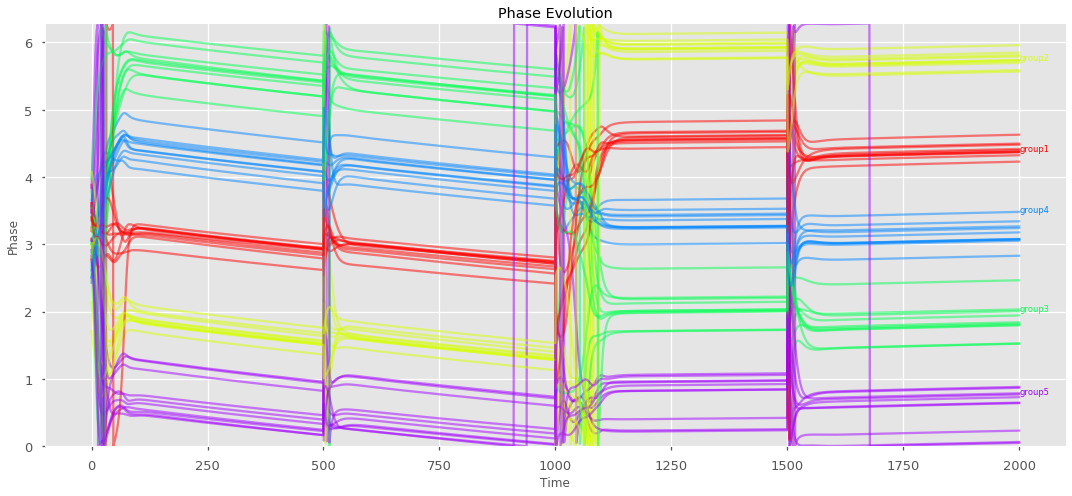

<Figure size 432x288 with 0 Axes>

In [36]:
plt.figure(figsize=(15,7))
phase_evol(Trainer.phases,Trainer.masks.unsqueeze(0).data.numpy())

## Omega uniform

In [66]:
# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=50
n_groups = 5
transform='softmax'
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 200
alpha = 0.1
lr=1e-4
optimizer='Adam'
init_std = 1



num_in = n_nodes #+ 2*batch_size
hidden_size = 100
num_out = n_nodes*n_nodes

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=None,gain=0.5)
data_generator = fixed_graph(n_nodes, n_groups)
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std)

losses = Trainer.train(gradient_steps = 2000,num_loss=0, burn_in_prop=0.99,omega_bool=True)

Iteration 0. Loss: 1.2852689027786255. Time/flow: 0.558311939239502
Iteration 1. Loss: 1.4498370885849. Time/flow: 0.49280595779418945
Iteration 2. Loss: 1.4375025033950806. Time/flow: 0.5961077213287354
Iteration 3. Loss: 1.9147504568099976. Time/flow: 0.4913640022277832
Iteration 4. Loss: 1.0569055080413818. Time/flow: 0.5646519660949707
Iteration 5. Loss: 1.3578068017959595. Time/flow: 0.5178327560424805
Iteration 6. Loss: 1.636955738067627. Time/flow: 0.5787539482116699
Iteration 7. Loss: 0.9945184588432312. Time/flow: 0.5342485904693604
Iteration 8. Loss: 0.8059760928153992. Time/flow: 0.549248456954956
Iteration 9. Loss: 1.181376338005066. Time/flow: 0.5390479564666748
Iteration 10. Loss: 1.1245174407958984. Time/flow: 0.5148215293884277
Iteration 11. Loss: 1.1610075235366821. Time/flow: 0.5058250427246094
Iteration 12. Loss: 0.8650774955749512. Time/flow: 0.576286792755127
Iteration 13. Loss: 1.2231930494308472. Time/flow: 0.5513417720794678
Iteration 14. Loss: 0.942492187023162

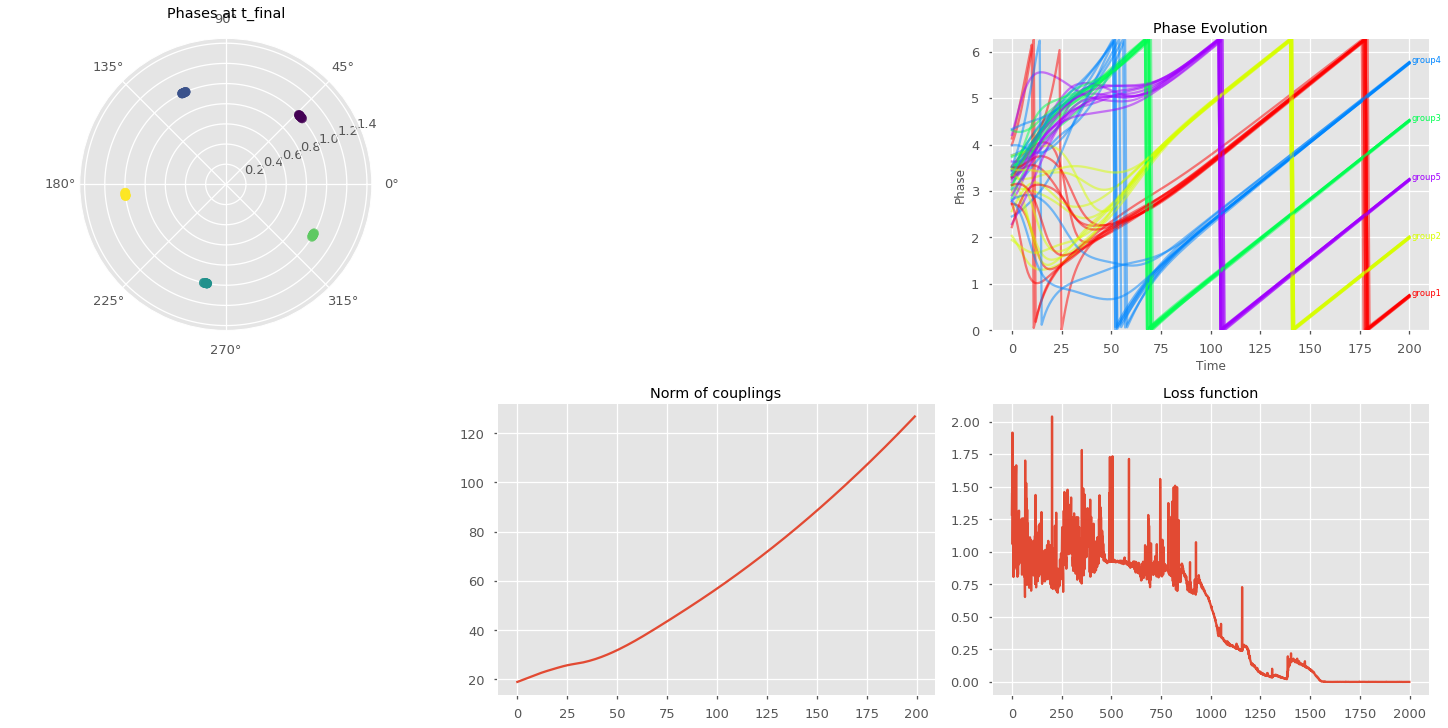

In [67]:
init_phase = Trainer.init
a = Trainer.batch
idx = Trainer.idx
phase = Trainer.phases
couplings = torch.stack(Trainer.couplings).reshape(200,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
#ax = fig.add_subplot(spec4[0, 1])
#ax.set_title('Classification')
#ecolors = [cm.jet(x*10) for x in idx]
#colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
#ax.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)
#ax = fig.add_subplot(spec4[1,0])
#ax.set_title('Couplings matrix')
#ax.imshow(couplings.detach().numpy())
#ax.colorbar()
#ax.set_axis('off')
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
ax.plot(torch.pow(couplings,2).sum((1,2)).detach().numpy())
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
plt.savefig('circles classification',dpi=200)
plt.show()

In [143]:
Trainer.init_std = 1
perturbation = dict(zip([],[]))
#perturbation = dict(zip([1000],[torch.normal(0,2,(n_nodes,)).float().unsqueeze(0)]))
Trainer.run_perturbation(perturbations=perturbation,kuramoto_steps=5000)
phase1 = Trainer.phases.squeeze(1).detach().numpy()

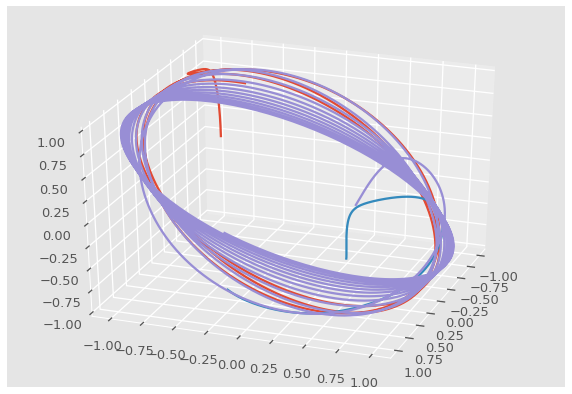

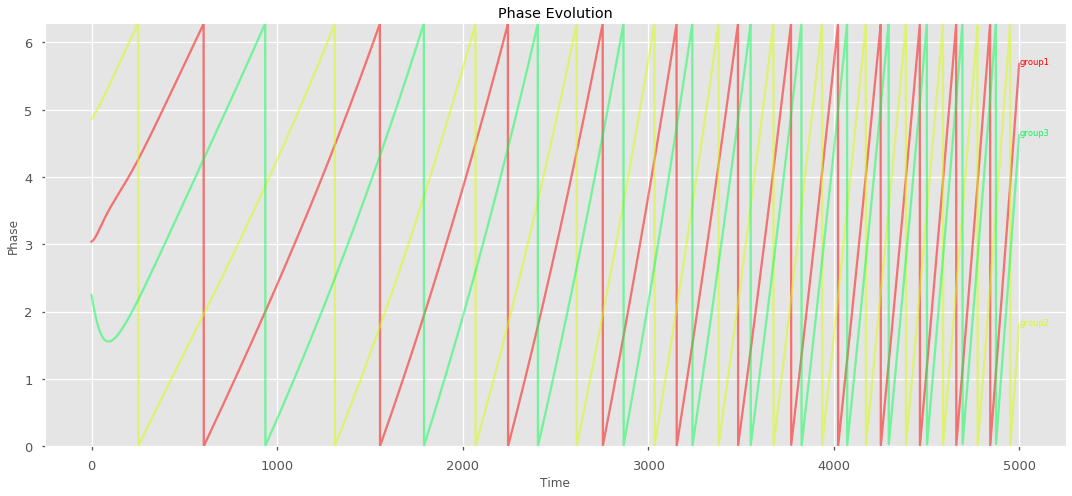

In [146]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
phase = Trainer.phases.squeeze(1).detach().numpy()#%(2*np.pi)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(np.cos(phase1[:,0]), np.cos(phase1[:,1]), np.cos(phase1[:,2]))
ax.plot(np.cos(phase2[:,0]), np.cos(phase2[:,1]), np.cos(phase2[:,2]))
ax.plot(np.cos(phase3[:,0]), np.cos(phase3[:,1]), np.cos(phase3[:,2]))
#ax.plot(np.cos(phase_perturbation[:,0]), np.cos(phase_perturbation[:,1]), np.cos(phase_perturbation[:,2]))
#ax.plot(np.cos(phase_perturbation2[:,0]), np.cos(phase_perturbation2[:,1]), np.cos(phase_perturbation2[:,2]))
ax.view_init(elev=30, azim=20)
plt.show()
plt.figure(figsize=(15,7))
phase_evol(Trainer.phases,Trainer.masks.unsqueeze(0).data.numpy())

In [156]:
# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=3
n_groups = 3
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 300
alpha = 0.05
lr=1e-4
optimizer='Adam'
init_std = 1



num_in = n_nodes #+ 2*batch_size
hidden_size = 100
num_out = n_nodes*n_nodes

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=None,gain=0.5)
data_generator = fixed_graph(n_nodes, n_groups)
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std)

losses = Trainer.train(gradient_steps = 500,num_loss=0, burn_in_prop=0.99,omega_bool=False)

Iteration 0. Loss: 0.09323842823505402. Time/flow: 0.5643341541290283
Iteration 1. Loss: 0.770513653755188. Time/flow: 0.4657711982727051
Iteration 2. Loss: 1.4671591520309448. Time/flow: 0.7241053581237793
Iteration 3. Loss: 0.41803988814353943. Time/flow: 0.5125105381011963
Iteration 4. Loss: 0.8640543222427368. Time/flow: 0.7154335975646973
Iteration 5. Loss: 0.6517564654350281. Time/flow: 0.604536771774292
Iteration 6. Loss: 1.1813502311706543. Time/flow: 0.6563472747802734
Iteration 7. Loss: 0.2480330765247345. Time/flow: 0.6727039813995361
Iteration 8. Loss: 1.2228031158447266. Time/flow: 0.5666062831878662
Iteration 9. Loss: 0.3114996552467346. Time/flow: 0.757941722869873
Iteration 10. Loss: 0.19629763066768646. Time/flow: 0.5433065891265869
Iteration 11. Loss: 0.18866929411888123. Time/flow: 0.6499180793762207
Iteration 12. Loss: 0.14937078952789307. Time/flow: 0.5584762096405029
Iteration 13. Loss: 0.17040710151195526. Time/flow: 0.6374013423919678
Iteration 14. Loss: 0.31412

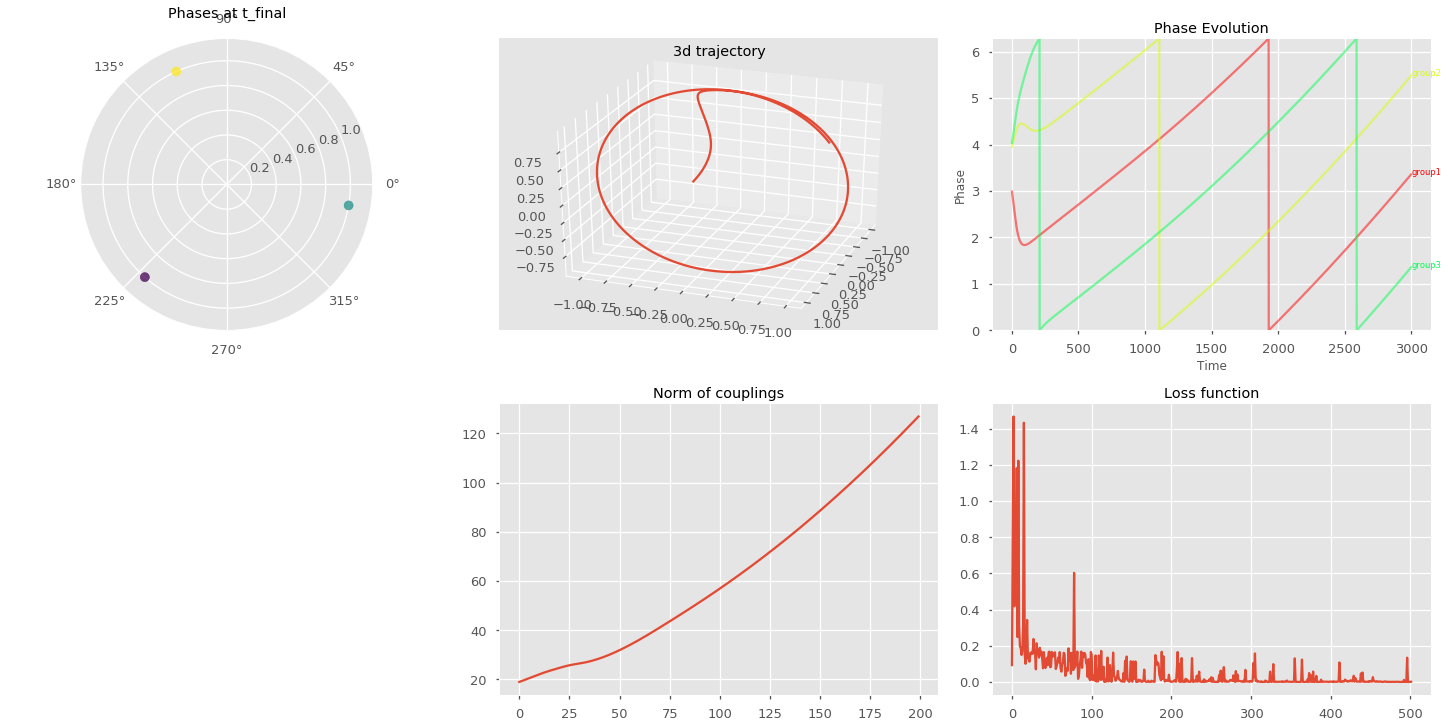

In [158]:
Trainer.init_std = 1
init_phase = Trainer.init
a = Trainer.batch
idx = Trainer.idx
phase = Trainer.phases
perturbation = dict(zip([],[]))
Trainer.run_perturbation(perturbations=perturbation,kuramoto_steps=3000)
phase1 = Trainer.phases.squeeze(1).detach().numpy()
#couplings = torch.stack(Trainer.couplings).reshape(200,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1], projection='3d')
ax.set_title('3d trajectory')
ax.plot(np.cos(phase1[:,0]), np.cos(phase1[:,1]), np.cos(phase1[:,2]))
ax.view_init(elev=30, azim=20)
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
ax.plot(torch.pow(couplings,2).sum((1,2)).detach().numpy())
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase1,masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
#plt.savefig('feedback control 3D',dpi=200)
plt.show()

In [47]:
# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=50
n_groups = 3
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 300
alpha = 0.05
lr=1e-4
optimizer='Adam'
init_std = 1



num_in = n_nodes #+ 2*batch_size
hidden_size = 100
num_out = n_nodes*n_nodes

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=None,gain=0.5)
data_generator = fixed_graph(n_nodes, n_groups)
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std, feedback=False)

losses = Trainer.train(gradient_steps = 1000,num_loss=0, burn_in_prop=0.99, omega_bool=True)

Iteration 0. Loss: 1.7087135314941406. Time/flow: 0.16354131698608398
Iteration 1. Loss: 1.7215557098388672. Time/flow: 0.2506749629974365
Iteration 2. Loss: 0.9085826277732849. Time/flow: 0.1168365478515625
Iteration 3. Loss: 1.2009027004241943. Time/flow: 0.11742520332336426
Iteration 4. Loss: 0.7777665257453918. Time/flow: 0.11868572235107422
Iteration 5. Loss: 1.5050773620605469. Time/flow: 0.11724519729614258
Iteration 6. Loss: 0.703938364982605. Time/flow: 0.11552262306213379
Iteration 7. Loss: 1.1470508575439453. Time/flow: 0.1694192886352539
Iteration 8. Loss: 1.1886645555496216. Time/flow: 0.3410627841949463
Iteration 9. Loss: 1.1181429624557495. Time/flow: 0.34075498580932617
Iteration 10. Loss: 1.9698476791381836. Time/flow: 0.2874565124511719
Iteration 11. Loss: 1.4758491516113281. Time/flow: 0.1786658763885498
Iteration 12. Loss: 2.2816457748413086. Time/flow: 0.18201136589050293
Iteration 13. Loss: 0.9021703004837036. Time/flow: 0.1966714859008789
Iteration 14. Loss: 1.61

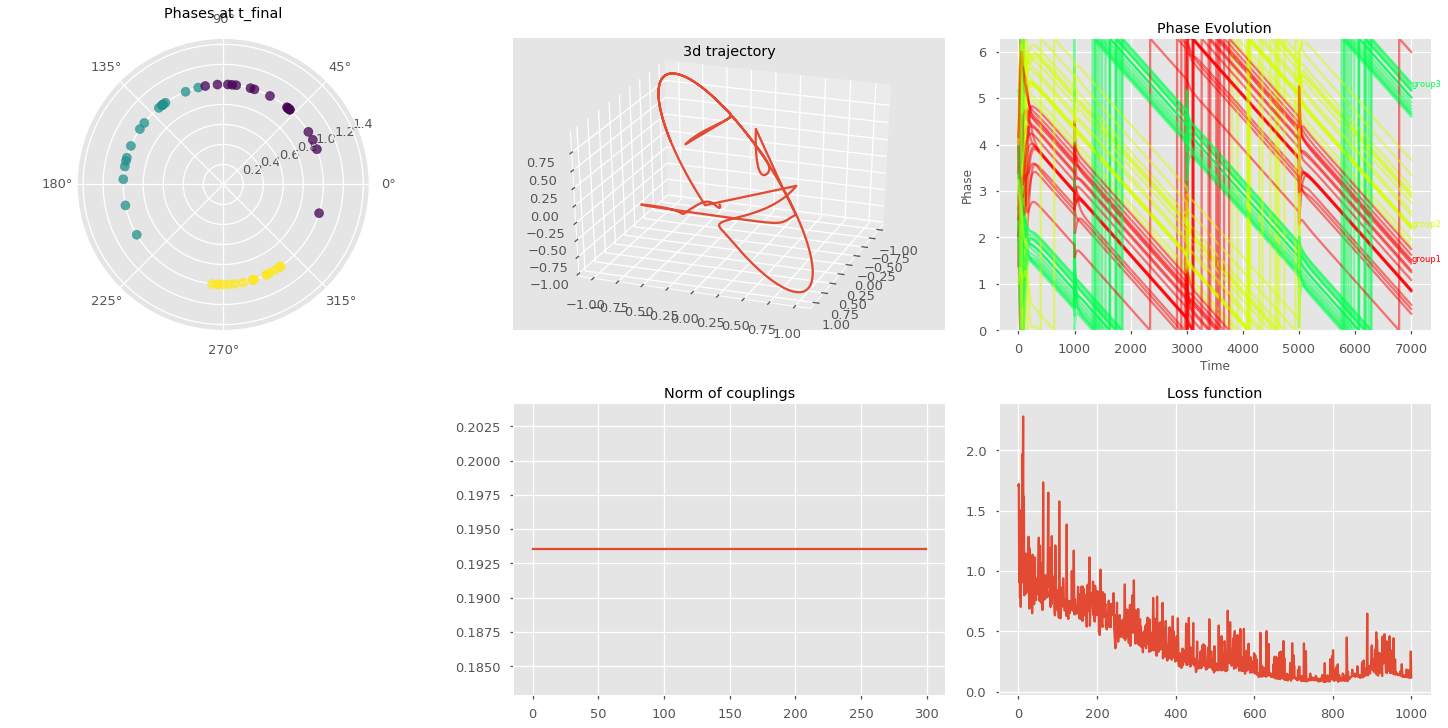

In [48]:
init_phase = Trainer.init
a = Trainer.batch
idx = Trainer.idx
#perturbation = dict(zip([],[]))
perturbation = dict(zip([1000,3000,5000],[torch.normal(0,0.5,(n_nodes,)).float().unsqueeze(0) for i in range(3)]))
Trainer.run_perturbation(perturbations=perturbation,kuramoto_steps=7000)
phase = Trainer.phases
phase1 = Trainer.phases.squeeze(1).detach().numpy()
#couplings = torch.stack(Trainer.couplings).reshape(300,3,3)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1], projection='3d')
ax.set_title('3d trajectory')
ax.plot(np.cos(phase1[:,0]), np.cos(phase1[:,1]), np.cos(phase1[:,2]))
ax.view_init(elev=30, azim=20)
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
ax.plot(torch.pow(couplings,2).sum((1,2)).detach().numpy())
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase1,masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
#plt.savefig('feedback control 3D',dpi=200)
plt.show()

In [49]:
Trainer.feedback

False

In [ ]:
# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=50
n_groups = 3
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 300
alpha = 0.1
lr=1e-4
optimizer='Adam'
init_std = 1



num_in = n_nodes #+ 2*batch_size
hidden_size = 100
num_out = n_nodes*n_nodes

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=None,gain=0.5)
data_generator = fixed_graph(n_nodes, n_groups)
LossFunc = circular_moments_batch
Trainer_no_feedback =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std, feedback=False)

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=None,gain=0.5)
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std, feedback=False)

losses_no = Trainer_no_feedback.train(gradient_steps = 1000,num_loss=0, burn_in_prop=0.99, omega_bool=False)
losses = Trainer.train(gradient_steps = 1000,num_loss=0, burn_in_prop=0.99, omega_bool=False)

Iteration 0. Loss: 0.992913007736206. Time/flow: 0.1668996810913086
Iteration 1. Loss: 0.7880141735076904. Time/flow: 0.21551728248596191
Iteration 2. Loss: 0.8648611903190613. Time/flow: 0.2126166820526123
Iteration 3. Loss: 0.8283510804176331. Time/flow: 0.27660346031188965
Iteration 4. Loss: 1.57942795753479. Time/flow: 0.20763897895812988
Iteration 5. Loss: 0.8853692412376404. Time/flow: 0.2500615119934082
Iteration 6. Loss: 0.8599250316619873. Time/flow: 0.12536120414733887
Iteration 7. Loss: 0.8644214868545532. Time/flow: 0.12014222145080566
Iteration 8. Loss: 0.9163604974746704. Time/flow: 0.13309216499328613
Iteration 9. Loss: 1.4323785305023193. Time/flow: 0.13111042976379395
Iteration 10. Loss: 1.1423091888427734. Time/flow: 0.1145315170288086
Iteration 11. Loss: 0.9944514632225037. Time/flow: 0.11744523048400879
Iteration 12. Loss: 1.0422078371047974. Time/flow: 0.11429071426391602
Iteration 13. Loss: 1.1017990112304688. Time/flow: 0.16469335556030273
Iteration 14. Loss: 0.9